# Bicycle Demand Prediction

AIM: To predict the demand of bicycles every hour to make sure adequate amount of bicycles are available for travel.

In [2]:
#Imports
import pandas as pd
pd.pandas.set_option('display.max_columns', None)

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import scipy
from scipy.stats import skew, kurtosis

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import kruskal
from scipy.stats import mannwhitneyu

## Data Analysis
This notebook consists of analyzing the dataset to understand the trends and patterns in the dataset to create accurate models for demand prediction.


### Load the Dataset

In [3]:
# Import Data
path = '/Users/manueljohn/Training/github-projects/bike-demand-prediction/artifacts/raw_data/SeoulBikeData.csv'
raw_df = pd.read_csv(path, encoding='unicode_escape')

print("Total Rows and features are: , ", raw_df.shape)
raw_df.head()

Total Rows and features are: ,  (8760, 14)


,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [4]:
# Columns
print(f"Different features are {raw_df.columns}")

Different features are Index(['Date', 'Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day'],
      dtype='object')


1. Date : year-month-day
2. Rented Bike count - Count of bikes rented at each hour
3. Hour - Hour of he day
4. Temperature-Temperature in Celsius
5. Humidity - %
6. Windspeed - m/s
7. Visibility - 10m
8. Dew point temperature - Celsius 
9. Solar radiation - MJ/m2
10. Rainfall - mm
11. Snowfall - cm
12. Seasons - Winter, Spring, Summer, Autumn
13. Holiday - Holiday/No holiday
14. Functional Day - NoFunc(Non Functional Hours), Fun(Functional hours)

Here, our target feature is the Rented Bike Count. All other features are the independent features.


#### 1. Clean Column names

In [5]:
#name mapper
column_name_mapper = {'Temperature(°C)': 'Temperature', 'Humidity(%)': 'Humidity', 
                      'Wind speed (m/s)': 'Wind speed', 'Visibility (10m)': 'Visibility', 
                      'Dew point temperature(°C)': 'Dew point temperature', 'Solar Radiation (MJ/m2)': 'Solar Radiation', 
                      'Rainfall(mm)': 'Rainfall', 'Snowfall (cm)': 'Snowfall'
                      }

def clean_col_names(df: pd.DataFrame, column_name_mapper: dict) -> pd.DataFrame:
    df = df.rename(columns=column_name_mapper)  # rename
    df.columns = df.columns.str.lower() # lower case
    df.columns = df.columns.str.replace('\s+', '_', regex=True) # replace space with '_'

    return df

# apply function
raw_df = clean_col_names(raw_df, column_name_mapper=column_name_mapper)
raw_df.columns, len(raw_df.columns)

(Index(['date', 'rented_bike_count', 'hour', 'temperature', 'humidity',
        'wind_speed', 'visibility', 'dew_point_temperature', 'solar_radiation',
        'rainfall', 'snowfall', 'seasons', 'holiday', 'functioning_day'],
       dtype='object'),
 14)

### Descriptive Stats

Checking the basic statistics of the data.

In [6]:
# Dataframe Info
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   8760 non-null   object 
 1   rented_bike_count      8760 non-null   int64  
 2   hour                   8760 non-null   int64  
 3   temperature            8760 non-null   float64
 4   humidity               8760 non-null   int64  
 5   wind_speed             8760 non-null   float64
 6   visibility             8760 non-null   int64  
 7   dew_point_temperature  8760 non-null   float64
 8   solar_radiation        8760 non-null   float64
 9   rainfall               8760 non-null   float64
 10  snowfall               8760 non-null   float64
 11  seasons                8760 non-null   object 
 12  holiday                8760 non-null   object 
 13  functioning_day        8760 non-null   object 
dtypes: float64(6), int64(4), object(4)
memory usage: 958.2+ 

In [7]:
raw_df.describe(include='all')

,date,rented_bike_count,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,solar_radiation,rainfall,snowfall,seasons,holiday,functioning_day
count,8760,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760,8760,8760
unique,365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,2
top,01/12/2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spring,No Holiday,Yes
freq,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2208,8328,8465
mean,NaN,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068,NaN,NaN,NaN
std,NaN,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746,NaN,NaN,NaN
min,NaN,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000,NaN,NaN,NaN
25%,NaN,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000,NaN,NaN,NaN
50%,NaN,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000,NaN,NaN,NaN
75%,NaN,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000,NaN,NaN,NaN


Seems like there are no null values and most of the values makes sense and less inconsistency. 

### Exploratory Analysis
Dig into the dataframe and check for ambiguties and inconsistensies

In [8]:
#Basic Consistency Check
print(f"Number of Null values: \n{raw_df.isnull().sum()}", '\n\n')
print(f"Number of duplucates: \n {raw_df.duplicated().sum()} \n\n")

Number of Null values: 
date                     0
rented_bike_count        0
hour                     0
temperature              0
humidity                 0
wind_speed               0
visibility               0
dew_point_temperature    0
solar_radiation          0
rainfall                 0
snowfall                 0
seasons                  0
holiday                  0
functioning_day          0
dtype: int64 


Number of duplucates: 
 0 




In [9]:
#Total Unique Values in each column
raw_df.nunique()

date                      365
rented_bike_count        2166
hour                       24
temperature               546
humidity                   90
wind_speed                 65
visibility               1789
dew_point_temperature     556
solar_radiation           345
rainfall                   61
snowfall                   51
seasons                     4
holiday                     2
functioning_day             2
dtype: int64

#### Univariate Analysis
THis section will cover the analysis of individual features and their distributions and anomalies.

In [10]:
raw_df.head()

,date,rented_bike_count,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,solar_radiation,rainfall,snowfall,seasons,holiday,functioning_day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [11]:
#Target
target_col = ['rented_bike_count']

#categorical columns
cat_cols = list(set(raw_df.select_dtypes(include=['O']).columns))

#numerical columns
num_cols = list(set(raw_df.select_dtypes(exclude=['O']).columns) - set(target_col))
discrete_cols = [i for i in num_cols if raw_df[i].nunique()<30]
cont_cols = [i for i in num_cols if i not in discrete_cols]

print(f"There are {len(cat_cols)} categorical features: {cat_cols}")
print(f"There are {len(num_cols)} numerical features: {num_cols}")
print(f"There are {len(discrete_cols)} discrete features: {discrete_cols}")
print(f"There are {len(cont_cols)} continuos features: {cont_cols}")

print(f"Target Column is : {target_col}")

There are 4 categorical features: ['date', 'holiday', 'functioning_day', 'seasons']
There are 9 numerical features: ['snowfall', 'humidity', 'wind_speed', 'temperature', 'rainfall', 'hour', 'dew_point_temperature', 'visibility', 'solar_radiation']
There are 1 discrete features: ['hour']
There are 8 continuos features: ['snowfall', 'humidity', 'wind_speed', 'temperature', 'rainfall', 'dew_point_temperature', 'visibility', 'solar_radiation']
Target Column is : ['rented_bike_count']


#####  Target Variable - rented_bike_count
Analyzing the target variable, its distribution to get idea on the feature.

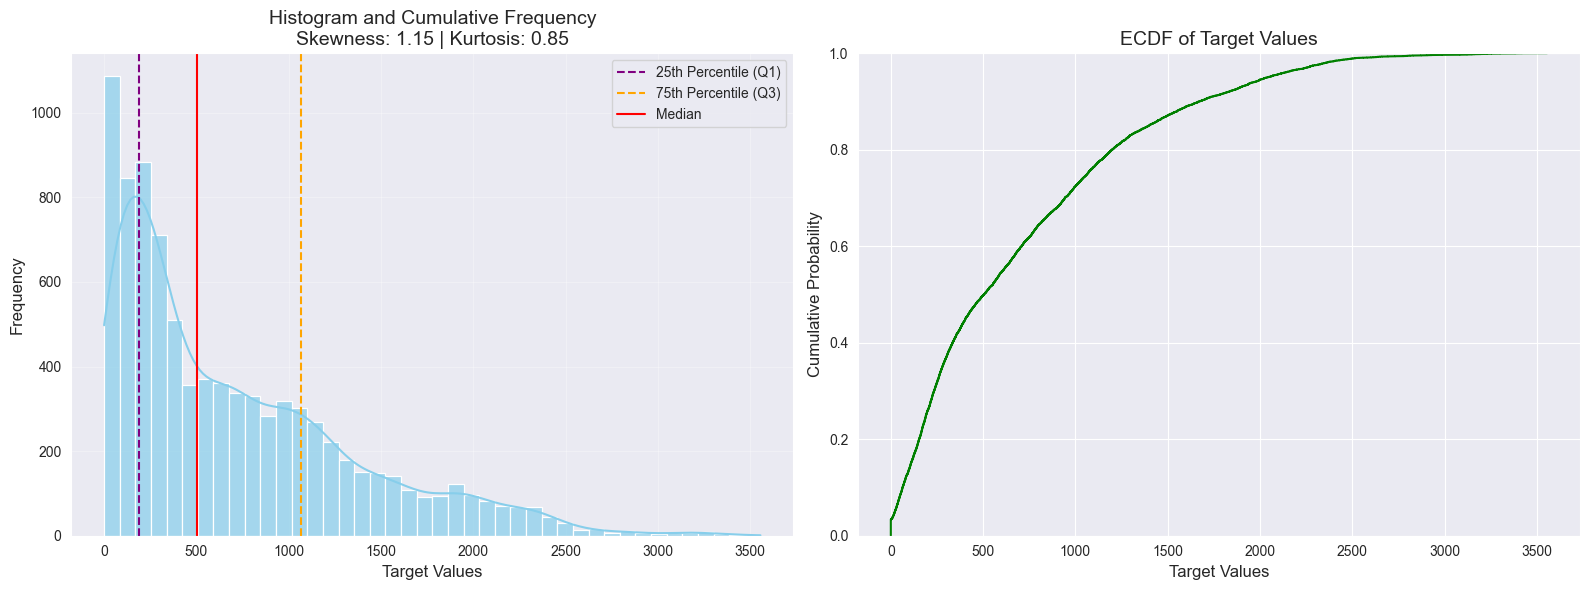

Skewness: 1.15
Kurtosis: 0.85
25th Percentile (Q1): 191.00
75th Percentile (Q3): 1065.25
Interquartile Range (IQR): 874.25


In [12]:
def plot_target_distribution(target, bins=30):
    """
    Plots the distribution of a target variable, calculates its skewness and kurtosis,
    and indicates where most values are concentrated using the IQR. Additionally,
    plots the ECDF of the target variable in a subplot.

    Parameters:
        target (array-like): Target variable data.
        bins (int): Number of bins for the histogram.
    """
    # Calculate skewness and kurtosis
    skewness = skew(target, nan_policy='omit')
    kurt = kurtosis(target, nan_policy='omit', fisher=True)
    
    # Calculate interquartile range (IQR)
    q1 = np.percentile(target, 25)
    q3 = np.percentile(target, 75)
    iqr = q3 - q1
    low = q1
    high = q3

    # Create a figure with 2 subplots (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Histogram and Cumulative Frequency on the first subplot
    sns.histplot(target, kde=True, color="skyblue", alpha=0.7,  ax=axes[0])

    axes[0].set_title(f"Histogram and Cumulative Frequency\nSkewness: {skewness:.2f} | Kurtosis: {kurt:.2f}", fontsize=14)
    axes[0].set_xlabel('Target Values', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    
    # Calculate and plot cumulative frequency
    counts, bin_edges = np.histogram(target, bins=bins)
    
    # Add percentile lines to histogram
    axes[0].axvline(low, color='purple', linestyle='--', label='25th Percentile (Q1)')
    axes[0].axvline(high, color='orange', linestyle='--', label='75th Percentile (Q3)')
    axes[0].axvline(np.median(target), color='red', linestyle='-', label='Median')
    
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # ECDF plot on the second subplot
    sns.ecdfplot(target, ax=axes[1], color='green')
    axes[1].set_title('ECDF of Target Values', fontsize=14)
    axes[1].set_xlabel('Target Values', fontsize=12)
    axes[1].set_ylabel('Cumulative Probability', fontsize=12)

    # Adjust layout for tight spaces
    plt.tight_layout()
    plt.show()

    # Print summary
    print(f"Skewness: {skewness:.2f}")
    print(f"Kurtosis: {kurt:.2f}")
    print(f"25th Percentile (Q1): {low:.2f}")
    print(f"75th Percentile (Q3): {high:.2f}")
    print(f"Interquartile Range (IQR): {iqr:.2f}")

plot_target_distribution(raw_df[target_col[0]])

It seems like 90% of the time the demand is below 2000, but there at some peak pointsm the demand rises are goes beyond 2000 units per hour. We need to analyze when exaclty this spike occurs to handle the demand accurately. 50% of the time the demand is below 500 units per hour.

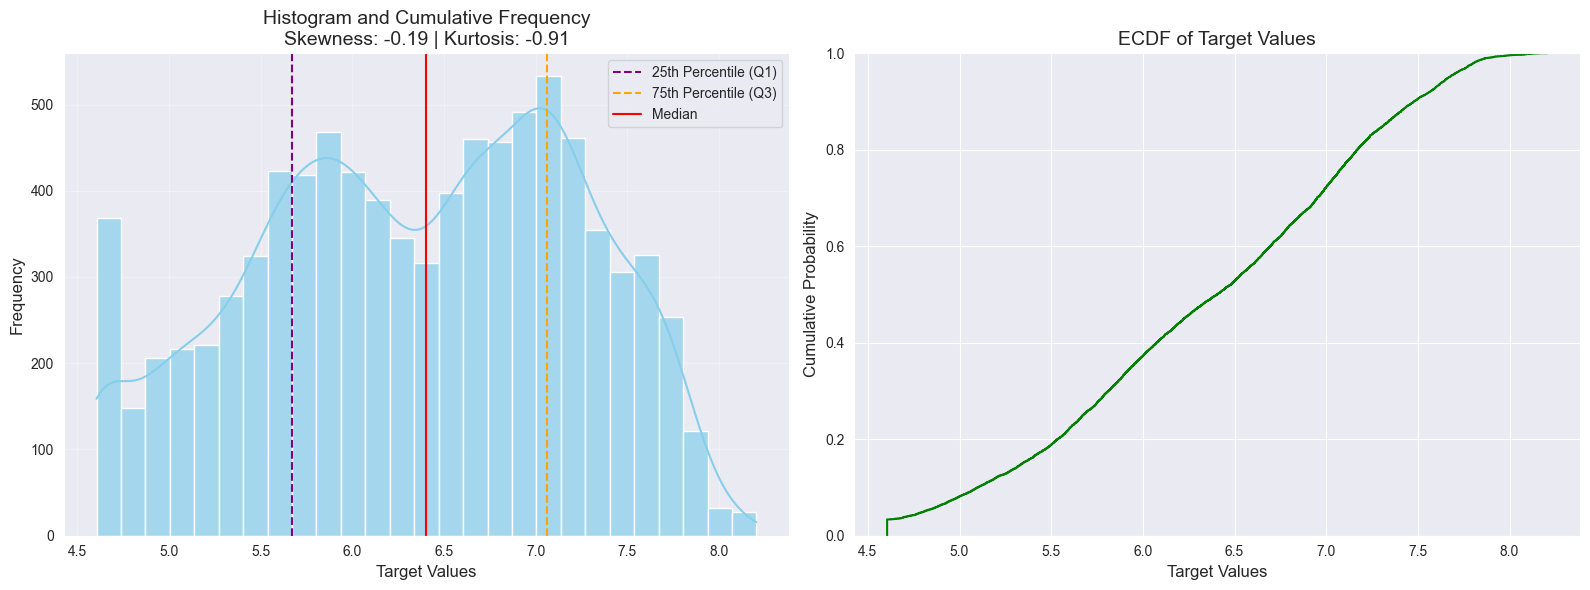

Skewness: -0.19
Kurtosis: -0.91
25th Percentile (Q1): 5.67
75th Percentile (Q3): 7.06
Interquartile Range (IQR): 1.39


In [ ]:
#Log Distribution of the target.
plot_target_distribution(np.log(raw_df[target_col[0]]+100))

##### Independent Features - Discrete Numerical

Analyzing discrete variables

In [13]:
print(f"Discrete Features are: {discrete_cols}")

Discrete Features are: ['hour']


We only have hour feature which is discrete, we can cehck and see if they are consistant.

In [14]:
print(f"Count of Each hours: {raw_df[discrete_cols[0]].value_counts()}.")

Count of Each hours: hour
0     365
1     365
22    365
21    365
20    365
19    365
18    365
17    365
16    365
15    365
14    365
13    365
12    365
11    365
10    365
9     365
8     365
7     365
6     365
5     365
4     365
3     365
2     365
23    365
Name: count, dtype: int64.


We have total of 365 days data, which contributes to one year.

##### Independent Features - Continuos Numerical

In [15]:
print(f"Continous Features are {cont_cols}")

Continous Features are ['snowfall', 'humidity', 'wind_speed', 'temperature', 'rainfall', 'dew_point_temperature', 'visibility', 'solar_radiation']


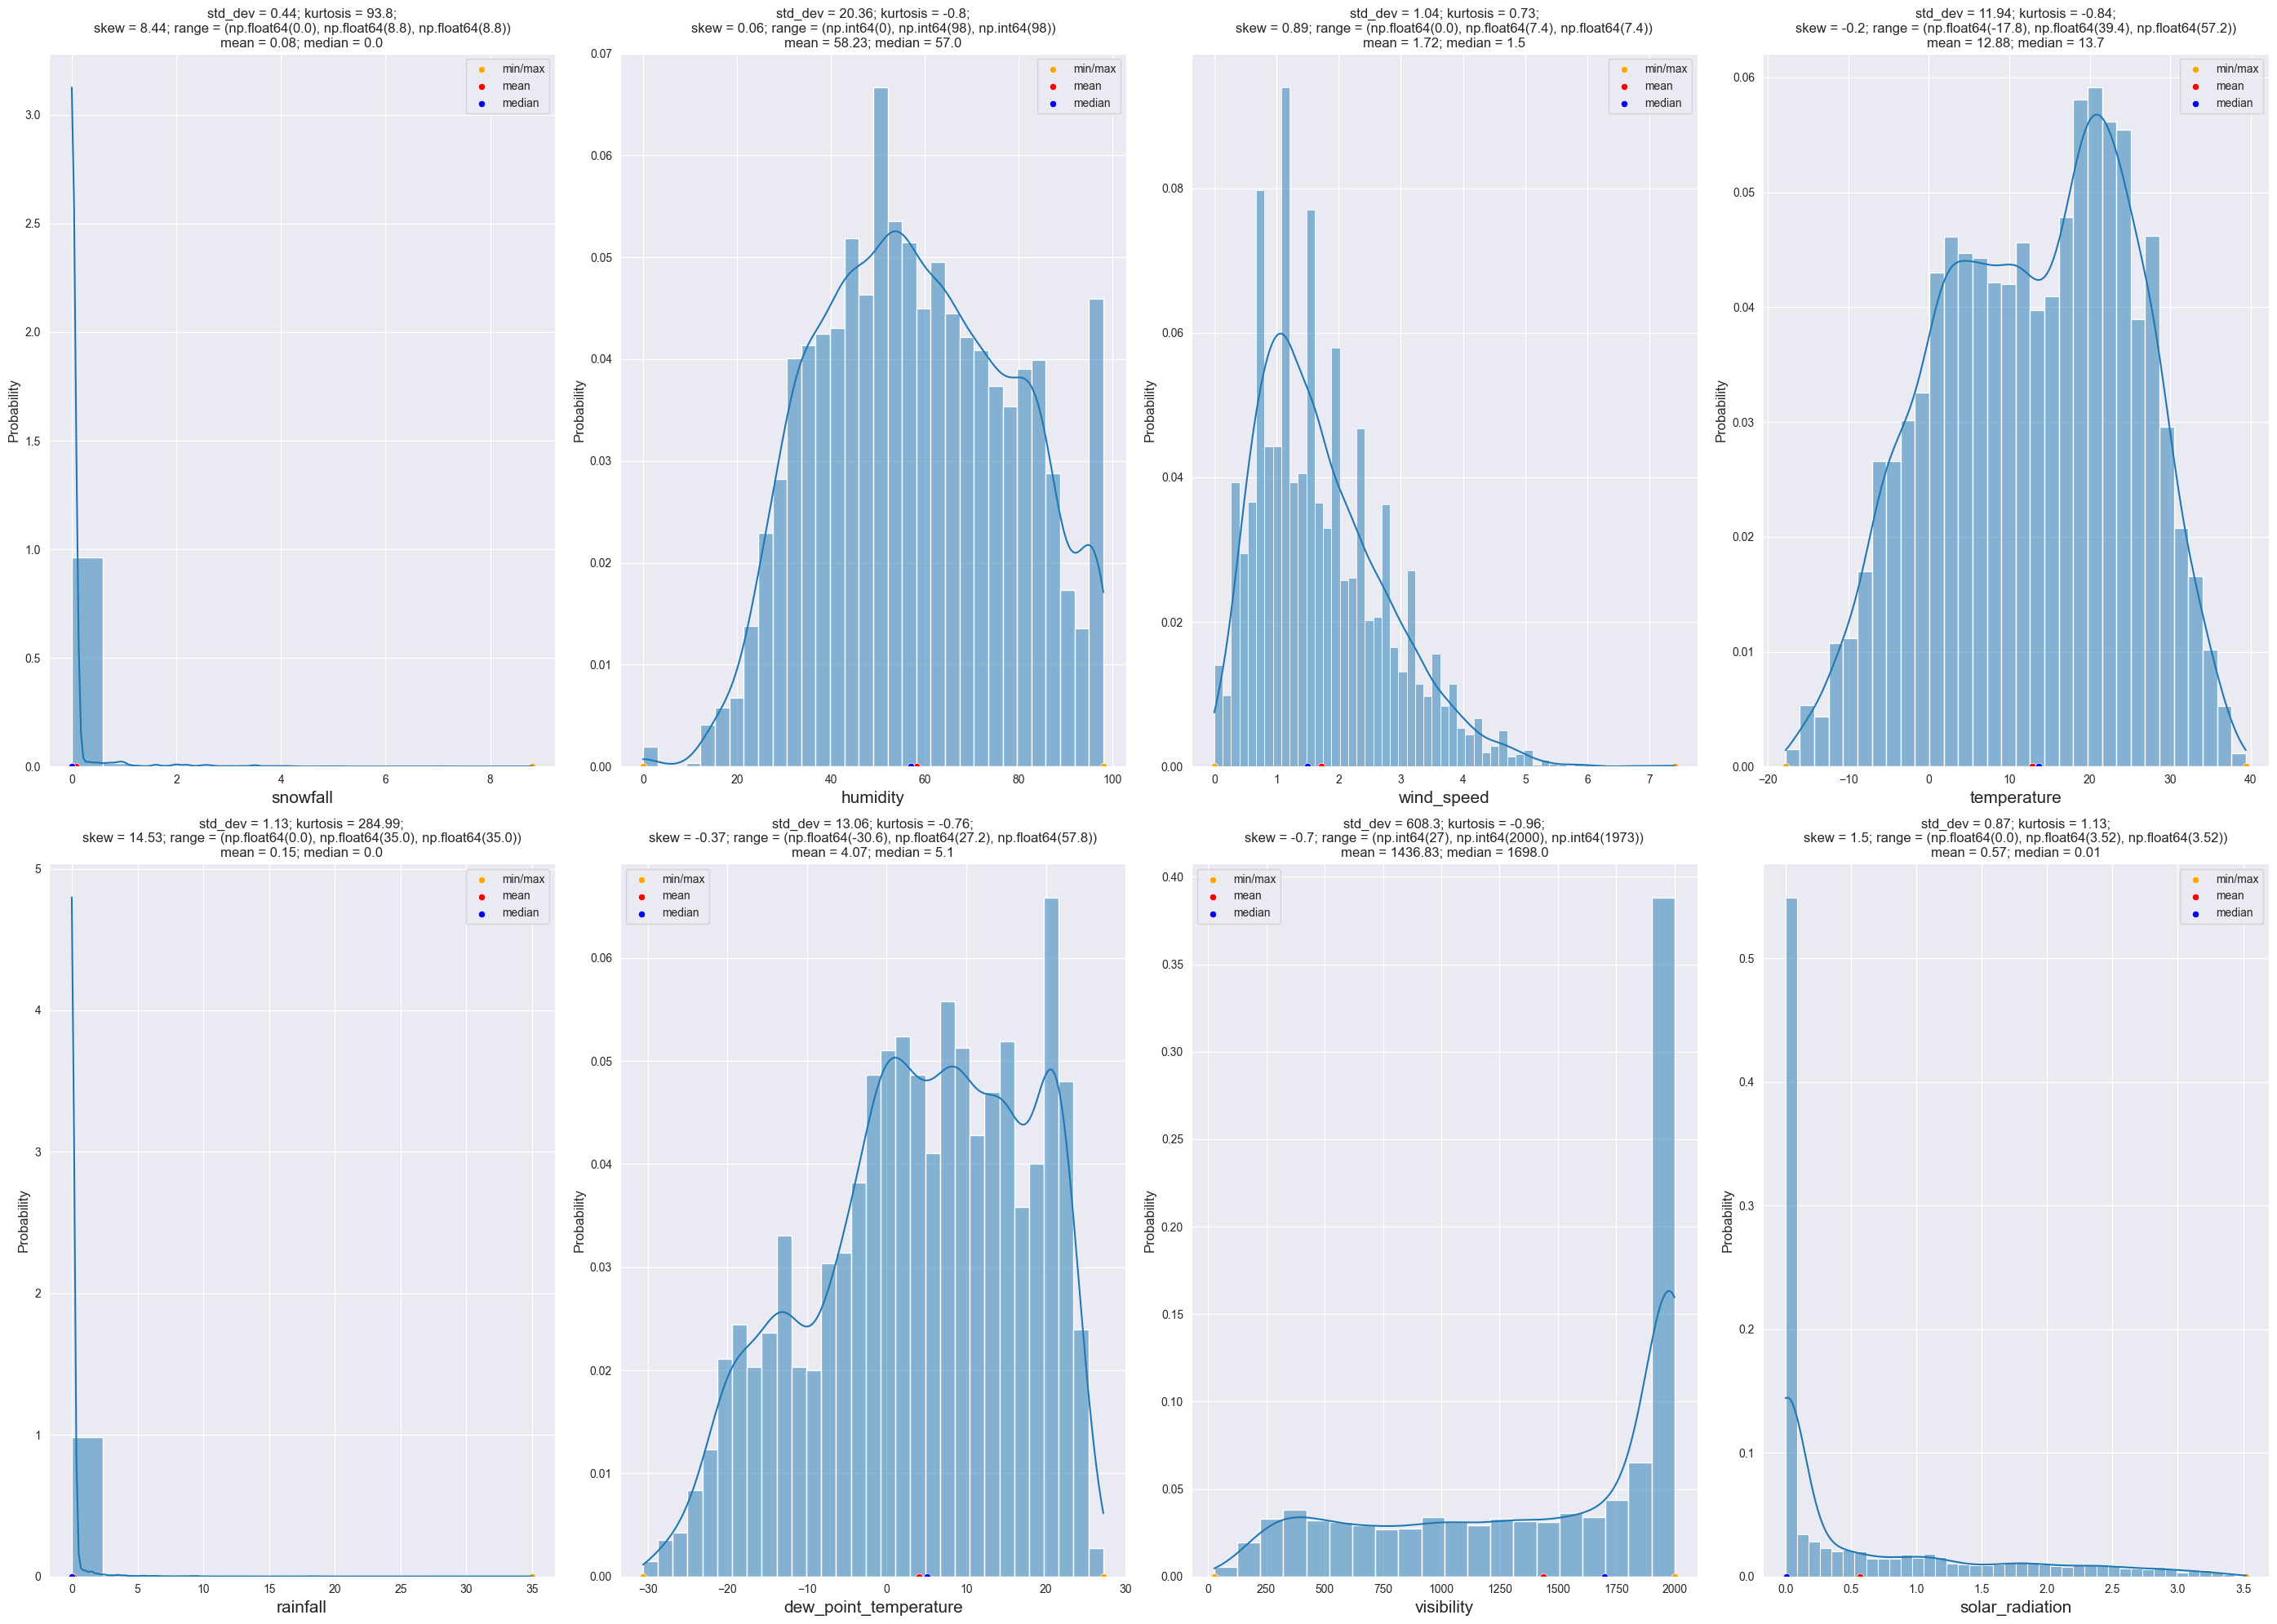

In [16]:
#Distribution of independant features
def UVA_numeric(data, var_group):
    '''
    Univariate_Analysis_numeric
    takes a group of variables (INTEGER and FLOAT) and plots all the descriptives and properties along with KDE.

    Ensures that there are only four plots per row.
    '''

    size = len(var_group)
    num_cols = 4
    num_rows = (size // num_cols) + (size % num_cols > 0)  # Calculate required rows

    plt.figure(figsize=(7 * num_cols, 10 * num_rows), dpi=100)

    # Looping for each variable
    for j, i in enumerate(var_group):
        # Calculating descriptives of the variable
        mini = data[i].min()
        maxi = data[i].max()
        ran = data[i].max() - data[i].min()
        mean = data[i].mean()
        median = data[i].median()
        st_dev = data[i].std()
        skew = data[i].skew()
        kurt = data[i].kurtosis()

        # Plotting the variable with every information
        plt.subplot(num_rows, num_cols, j + 1)
        hist_plot = sns.histplot(data[i], stat='probability', kde=True)
        sns.scatterplot(x=[mini, maxi], y=[0, 0], color='orange', label="min/max")
        sns.scatterplot(x=[mean], y=[0], color='red', label="mean")
        sns.scatterplot(x=[median], y=[0], color='blue', label="median")

        plt.xlabel(f'{i}', fontsize=15)
        plt.ylabel('Probability', fontsize=12)
        plt.title(
            'std_dev = {}; kurtosis = {};\nskew = {}; range = {}\nmean = {}; median = {}'.format(
                (round(st_dev, 2)),
                round(kurt, 2),
                round(skew, 2),
                (round(mini, 2), round(maxi, 2), round(ran, 2)),
                round(mean, 2),
                round(median, 2)),
            fontsize=12
        )

    plt.tight_layout()
    plt.show()

UVA_numeric(raw_df, cont_cols)

* Snowfall, Solar Radiation, rainfall, visibility has extreme skew and might need disctization technique. 

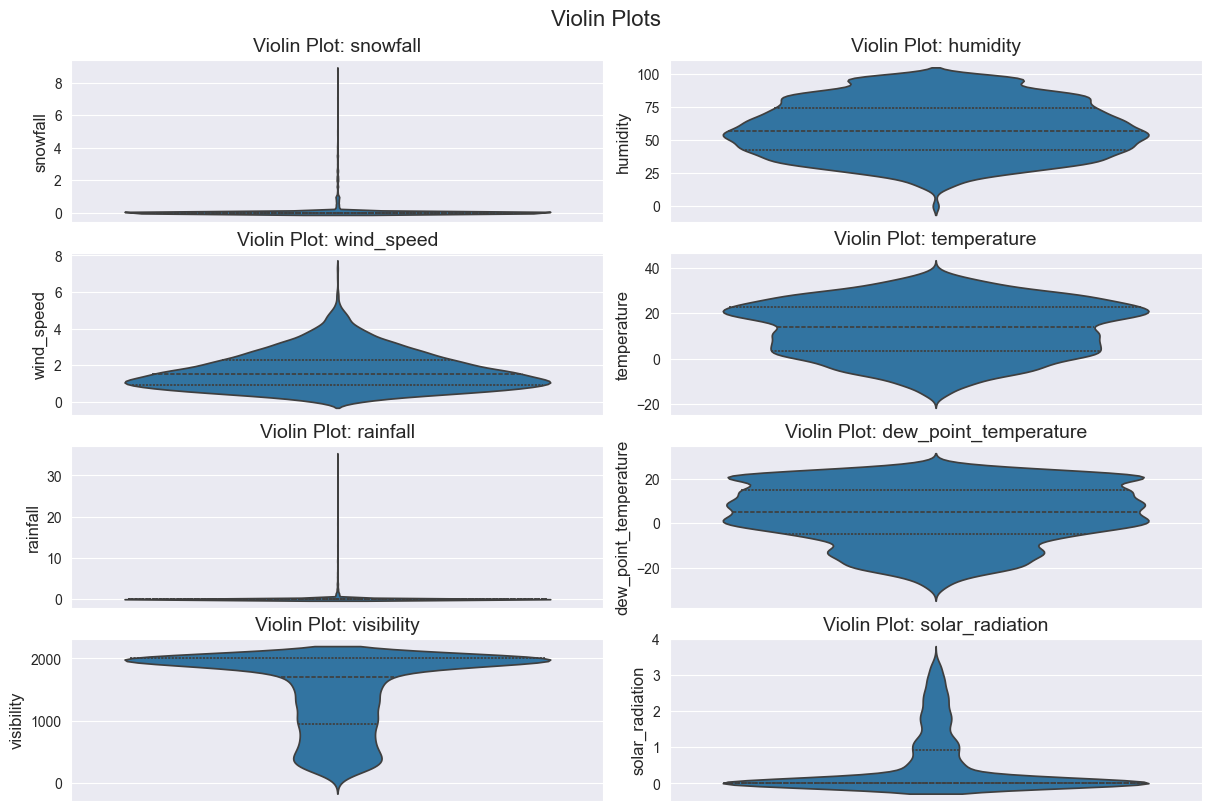

In [17]:
# Violin Plot
def plot_violin_subplots(data, columns, title="Violin Plots", figsize=(12, 8), ncols=2):
    """
    Plots violin plots for multiple numerical columns in subplots.
    
    Parameters:
    - data: pandas DataFrame containing the data.
    - columns: list of str, numerical columns to visualize.
    - category: str, optional, the categorical column for grouping.
    - title: str, the title of the plot.
    - figsize: tuple, size of the entire figure.
    - ncols: int, number of columns in the subplot grid.
    
    Returns:
    - A figure with subplots of violin plots.
    """
    nrows = -(-len(columns) // ncols)  # Calculate rows needed for subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, constrained_layout=True)
    
    # Flatten axes for easier iteration (works even if only 1 row/column)
    axes = axes.flatten()
    
    for i, col in enumerate(columns):
        sns.violinplot(data=data, y=col, ax=axes[i], inner="quartile")
        axes[i].set_ylabel(col, fontsize=12)
    
        axes[i].set_title(f"Violin Plot: {col}", fontsize=14)
    
    # Remove empty subplots
    for j in range(len(columns), len(axes)):
        fig.delaxes(axes[j])
    
    fig.suptitle(title, fontsize=16)
    plt.show()


plot_violin_subplots(raw_df, cont_cols)

In [18]:
def discrete_rainfall(df, col='rainfall'):
    # Define conditions for rainfall categories
    conditions = [
        df[col] == 0,
        (df[col] > 0) & (df[col] <= 3.5),
        (df[col] > 3.5)
        ]
    
    # Define corresponding category labels
    categories = ['No', 'Light', 'Medium']
    
    # Apply conditions to create the 'rainfall_class' column
    df['rainfall_class'] = np.select(conditions, categories, default='Unknown')
    
    return df

def discrete_snowfall(df, col='snowfall'):
    # Define conditions for snowfall categories
    conditions = [
        df[col] == 0,
        (df[col] > 0) & (df[col] <= 0.5),
        (df[col] > 0.5) & (df[col] <= 2.0),
        (df[col] > 2.0) & (df[col] <= 4.0),
        df[col] > 4.0
    ]
    
    # Define corresponding category labels
    categories = ['No', 'Light', 'Medium', 'Heavy', 'Extreme']
    
    # Apply conditions to create the 'snowfall_class' column
    df['snowfall_class'] = np.select(conditions, categories, default='Unknown')
    
    return df

def discrete_snowfall(df, col='snowfall'):
    # Define conditions for snowfall categories
    conditions = [
        df[col] == 0,
        (df[col] > 0) & (df[col] <= 0.5),
        (df[col] > 0.5) & (df[col] <= 2.0),
        (df[col] > 2.0)
    ]
    
    # Define corresponding category labels
    categories = ['No', 'Light', 'Medium', 'Heavy']
    
    # Apply conditions to create the 'snowfall_class' column
    df['snowfall_class'] = np.select(conditions, categories, default='Unknown')
    
    return df

def discrete_visibility(df, col='visibility'):    
    df[f'{col}_scaled'] = (df[col] * 10) / 1000

    # Define conditions for visibility categories
    conditions = [
        (df[f'{col}_scaled'] <= 5),
        (df[f'{col}_scaled'] > 5) & (df[f'{col}_scaled'] <= 10),
        df[f'{col}_scaled'] > 10
    ]

    # Define corresponding category labels
    categories = ['Poor', 'Moderate', 'Good']
    
    # Apply conditions to create the 'snowfall_class' column
    df['visibility_class'] = np.select(conditions, categories, default='Unknown')
    
    return df.drop([f'{col}_scaled'], axis=1)

def discrete_radiation(df, col='solar_radiation'):
    # Define conditions for visibility categories
    conditions = [
        df[col] <= 0.5,
        (df[col] > 0.5) & (df[col] <= 1),
        (df[col] > 1) & (df[col] <= 2.5),
        (df[col] > 2.5) & (df[col] <= 5),
        df[col] > 5
    ]

    # Define corresponding category labels
    categories = ['Very Low', 'Low', 'Moderate', 'High', 'Extreme']
    
    # Apply conditions to create the 'snowfall_class' column
    df['solar_radiation_class'] = np.select(conditions, categories, default='Unknown')
    
    return df


# Apply the discretization functions
raw_df = discrete_rainfall(raw_df)
raw_df = discrete_snowfall(raw_df)
raw_df = discrete_visibility(raw_df)
raw_df = discrete_radiation(raw_df)

cat_cols = list(set(cat_cols + raw_df.columns[raw_df.columns.str.endswith('_class')].to_list()))
print(f"Updated Categorical Columns are: {cat_cols} \n")

# Quality check
for col in raw_df.columns[raw_df.columns.str.endswith('_class')].to_list():
    print(f"The unique values in features are {raw_df[col].value_counts()} \n")

Updated Categorical Columns are: ['date', 'holiday', 'visibility_class', 'rainfall_class', 'solar_radiation_class', 'snowfall_class', 'functioning_day', 'seasons'] 

The unique values in features are rainfall_class
No        8232
Light      434
Medium      94
Name: count, dtype: int64 

The unique values in features are snowfall_class
No        8317
Medium     211
Heavy      118
Light      114
Name: count, dtype: int64 

The unique values in features are visibility_class
Good        6379
Moderate    1317
Poor        1064
Name: count, dtype: int64 

The unique values in features are solar_radiation_class
Very Low    5872
Moderate    1585
Low          813
High         490
Name: count, dtype: int64 



In [19]:
def analyse_rare_labels(df, var, rare_perc):
    df = df.copy()

    # determine the % of observations per category
    tmp = df.groupby(var)[target_col[0]].count() / len(df)

    # return categories that are rare
    return tmp[tmp < rare_perc]

# print categories that are present in less than
# 1 % of the observations

for var in cat_cols:
    print(analyse_rare_labels(raw_df, var, 0.01))
    print()

date
01/01/2018    0.00274
01/02/2018    0.00274
01/03/2018    0.00274
01/04/2018    0.00274
01/05/2018    0.00274
               ...   
31/05/2018    0.00274
31/07/2018    0.00274
31/08/2018    0.00274
31/10/2018    0.00274
31/12/2017    0.00274
Name: rented_bike_count, Length: 365, dtype: float64

Series([], Name: rented_bike_count, dtype: float64)

Series([], Name: rented_bike_count, dtype: float64)

Series([], Name: rented_bike_count, dtype: float64)

Series([], Name: rented_bike_count, dtype: float64)

Series([], Name: rented_bike_count, dtype: float64)

Series([], Name: rented_bike_count, dtype: float64)

Series([], Name: rented_bike_count, dtype: float64)



##### Categorical Feature Analysis
Analyzing the categorical features inclding the one we created.

In [20]:
raw_df[cat_cols]

,date,holiday,visibility_class,rainfall_class,solar_radiation_class,snowfall_class,functioning_day,seasons
0,01/12/2017,No Holiday,Good,No,Very Low,No,Yes,Winter
1,01/12/2017,No Holiday,Good,No,Very Low,No,Yes,Winter
2,01/12/2017,No Holiday,Good,No,Very Low,No,Yes,Winter
3,01/12/2017,No Holiday,Good,No,Very Low,No,Yes,Winter
4,01/12/2017,No Holiday,Good,No,Very Low,No,Yes,Winter
...,...,...,...,...,...,...,...,...
8755,30/11/2018,No Holiday,Good,No,Very Low,No,Yes,Autumn
8756,30/11/2018,No Holiday,Good,No,Very Low,No,Yes,Autumn
8757,30/11/2018,No Holiday,Good,No,Very Low,No,Yes,Autumn
8758,30/11/2018,No Holiday,Good,No,Very Low,No,Yes,Autumn


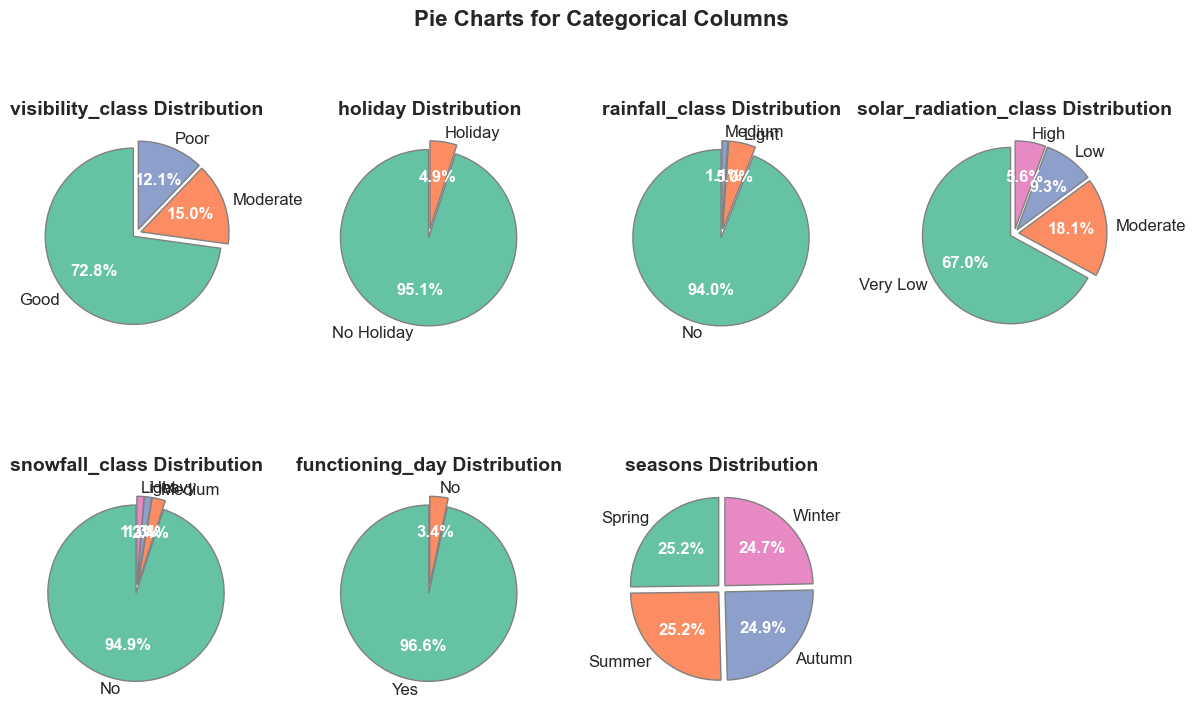

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_multiple_pie_charts(data, columns, title="Pie Charts for Categorical Columns", figsize=(12, 8), palette="Set2", explode_factor=0.05, ncols=4):
    """
    Plots multiple pie charts for different categorical columns in a grid layout.
    
    Parameters:
    - data: pandas DataFrame containing the data.
    - columns: list of str, categorical columns to visualize.
    - title: str, the title of the overall plot.
    - figsize: tuple, size of the entire figure.
    - palette: str or list, color palette for the slices.
    - explode_factor: float, factor to explode slices for better visualization (default 0.05).
    - ncols: int, number of columns in the subplot grid.
    
    Returns:
    - A figure with subplots of pie charts.
    """
    nrows = -(-len(columns) // ncols)  # Calculate rows needed for subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, constrained_layout=True)
    
    # Flatten axes for easier iteration (works even if there's 1 row/column)
    axes = axes.flatten()
    
    for i, col in enumerate(columns):
        category_counts = data[col].value_counts()
        labels = category_counts.index
        sizes = category_counts.values
        
        # Create explosion effect for all slices
        explode = [explode_factor] * len(labels)
        
        # Generate colors from the palette
        colors = sns.color_palette(palette, len(labels))
        
        # Plot pie chart
        wedges, texts, autotexts = axes[i].pie(
            sizes,
            labels=labels,
            autopct='%1.1f%%',
            startangle=90,
            explode=explode,
            colors=colors,
            textprops={'fontsize': 12},
            wedgeprops={'edgecolor': 'gray', 'linewidth': 1}
        )
        
        # Beautify the annotations
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontsize(12)
            autotext.set_fontweight('bold')
        
        # Title for each pie chart
        axes[i].set_title(f"{col} Distribution", fontsize=14, fontweight='bold')
    
    # Remove empty subplots if columns < total subplots
    for j in range(len(columns), len(axes)):
        fig.delaxes(axes[j])
    
    fig.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_multiple_pie_charts(raw_df, columns=set(cat_cols) - {'date'})

#### Bivariate Analysis

In this section we will analyze the interactions between two features.

##### Independent Continous vs Target Features

In [22]:
# Print Continous Indepentnt Features
print(cont_cols)

['snowfall', 'humidity', 'wind_speed', 'temperature', 'rainfall', 'dew_point_temperature', 'visibility', 'solar_radiation']


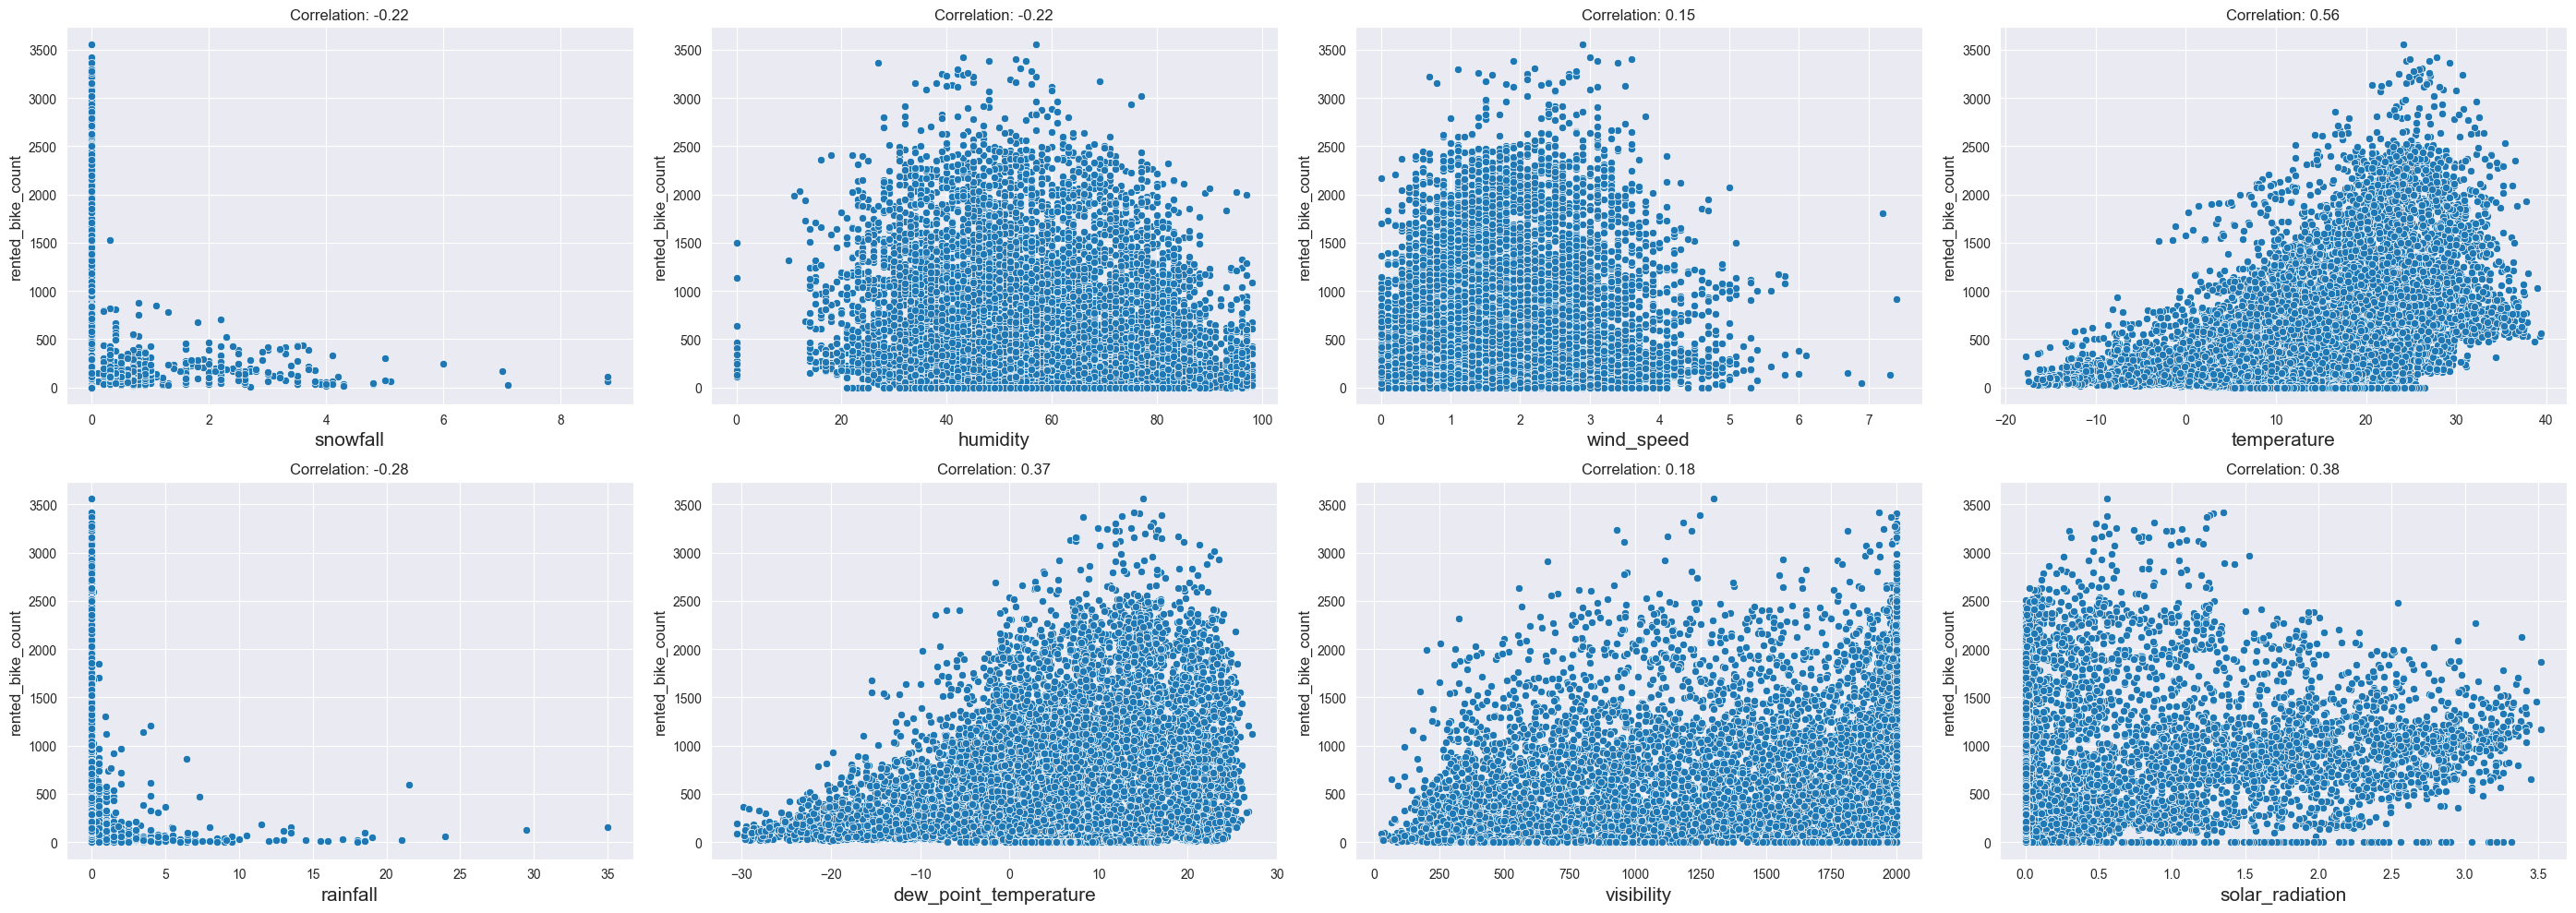

In [23]:
# Continuos Independent vs Target 
def scatter_plot(data, ind_group, target):
    '''
    Univariate_Analysis_numeric
    Takes a group of variables (INTEGER and FLOAT) and plots all the descriptives and properties along with KDE.
    
    Ensures that there are only four plots per row and reduces the figure size to avoid oversized plots.
    '''
    
    size = len(ind_group)
    num_cols = 4  # Set number of columns for the subplot grid
    num_rows = (size // num_cols) + (size % num_cols > 0)  # Calculate the number of rows needed

    # Dynamically adjust figure size to avoid exceeding limits
    fig_width = 7 * num_cols
    fig_height = 5 * num_rows  # Use smaller height per row

    # Ensure the figure size does not exceed a reasonable size
    fig_width = min(fig_width, 50)  # Maximum width of 20 inches
    fig_height = min(fig_height, 50)  # Maximum height of 20 inches

    plt.figure(figsize=(fig_width, fig_height), dpi=100)

    # Looping for each variable
    for j, i in enumerate(ind_group):
        # Calculating the correlation of the variable with the target
        corr = data[[i, target]].corr('spearman').iloc[0, 1]

        # Plotting the scatter plot for the variable
        plt.subplot(num_rows, num_cols, j + 1)
        sns.scatterplot(x=data[i], y=data[target])
        plt.title(f'Correlation: {corr:.2f}')
        plt.xlabel(f'{i}', fontsize=15)
        plt.ylabel(f'{target}', fontsize=12)

    plt.tight_layout()
    plt.show()

scatter_plot(raw_df, cont_cols, target_col[0])

* rented bike count has a correlation with temprature. There is an increase in rented bike count till25 degree and then decresing.

##### Multicollinearity in Independent Features

In [24]:
# Check multicollinearity Independent Pairs
def print_highly_correlated(df, features, threshold=0.5):
    corr_df = df[features].corr('spearman') # get correlations
    correlated_features = np.where(np.abs(corr_df) > threshold) # select ones above the abs threshold
    correlated_features = [(corr_df.iloc[x,y], x, y) for x, y in zip(*correlated_features) if x != y and x < y] # avoid duplication
    s_corr_list = sorted(correlated_features, key=lambda x: -abs(x[0])) # sort by correlation value

    pairs = {}

    if s_corr_list == []:
        print("There are no highly correlated features with correlation above", threshold)
    else:
        for v, i, j in s_corr_list:
            cols = df[features].columns
            pairs["%s and %s" % (corr_df.index[i], corr_df.columns[j])] = v

            # print ("%s and %s = %.3f" % (corr_df.index[i], corr_df.columns[j], v))

    return pairs

corr_pairs = print_highly_correlated(raw_df, cont_cols)
print("Correlated independent pairs: ", len(corr_pairs.keys()))

corr_pairs

Correlated independent pairs:  2


{'temperature and dew_point_temperature': np.float64(0.9115678638792739),
 'humidity and dew_point_temperature': np.float64(0.5210333034085842)}

We have dew_point_tempratireand temprature having high correlation, hence we need to remove one to reduce multicollinearity.
--> removing dew_point_temp.

In [25]:
# Remove higly correlated features
def remove_multicollinear_features(raw_df):
    features_to_remove = ['dew_point_temperature']

    return raw_df.drop(features_to_remove, axis=1)

raw_df = remove_multicollinear_features(raw_df)
num_cols.remove('dew_point_temperature')    # Update numerical column list
cont_cols.remove('dew_point_temperature')    # Update numerical column list

#Check correlation again
corr_pairs = print_highly_correlated(raw_df, cont_cols)
print("Correlated independent pairs: ", len(corr_pairs.keys()))

raw_df.head()


There are no highly correlated features with correlation above 0.5
Correlated independent pairs:  0


,date,rented_bike_count,hour,temperature,humidity,wind_speed,visibility,solar_radiation,rainfall,snowfall,seasons,holiday,functioning_day,rainfall_class,snowfall_class,visibility_class,solar_radiation_class
0,01/12/2017,254,0,-5.2,37,2.2,2000,0.0,0.0,0.0,Winter,No Holiday,Yes,No,No,Good,Very Low
1,01/12/2017,204,1,-5.5,38,0.8,2000,0.0,0.0,0.0,Winter,No Holiday,Yes,No,No,Good,Very Low
2,01/12/2017,173,2,-6.0,39,1.0,2000,0.0,0.0,0.0,Winter,No Holiday,Yes,No,No,Good,Very Low
3,01/12/2017,107,3,-6.2,40,0.9,2000,0.0,0.0,0.0,Winter,No Holiday,Yes,No,No,Good,Very Low
4,01/12/2017,78,4,-6.0,36,2.3,2000,0.0,0.0,0.0,Winter,No Holiday,Yes,No,No,Good,Very Low


##### Discrete Independent vs Target Features

In [26]:
# Discrete Independant vs Target
print(discrete_cols)

['hour']


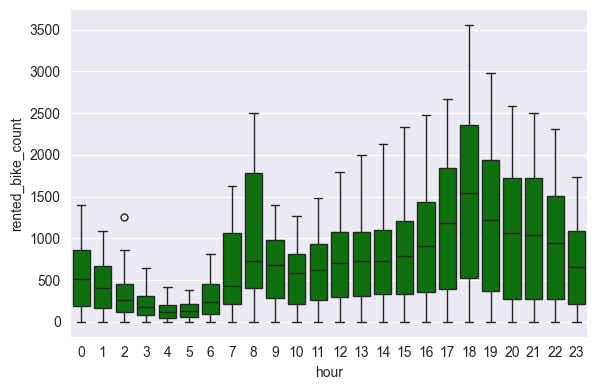

In [27]:
def plot_discrete_cols(df, cols):
    for var in cols:
        # make boxplot with Catplot
        sns.catplot(x=var, y=target_col[0], data=df, kind="box", height=4, aspect=1.5, color='g')
        plt.show()

plot_discrete_cols(raw_df, discrete_cols)

In [28]:
# Significance Test - Kruskal-Wallis H-test
grouped_data = [group['rented_bike_count'].values for name, group in raw_df.groupby('hour')]

f_statistic, p_value = kruskal(*grouped_data)
print(f"F-statistic: {f_statistic}, p-value: {p_value}")

F-statistic: 2369.961256210828, p-value: 0.0


* Using Kruskal Wallis Test, we have confimed that the groups doesnt have similar median, thereofre hour has effect on the rented bike counts.
* Most demand occurs between 5pm - 9pm and least between 2am to 5 am.

##### Categorical Vs Target Features

In [29]:
date_col = ['date']
cat_cols = list(set(cat_cols) - set(date_col))

#Categorical Columns
print(f"{cat_cols}")

['visibility_class', 'holiday', 'rainfall_class', 'solar_radiation_class', 'snowfall_class', 'functioning_day', 'seasons']


In [30]:
raw_df[cat_cols].head()

,visibility_class,holiday,rainfall_class,solar_radiation_class,snowfall_class,functioning_day,seasons
0,Good,No Holiday,No,Very Low,No,Yes,Winter
1,Good,No Holiday,No,Very Low,No,Yes,Winter
2,Good,No Holiday,No,Very Low,No,Yes,Winter
3,Good,No Holiday,No,Very Low,No,Yes,Winter
4,Good,No Holiday,No,Very Low,No,Yes,Winter


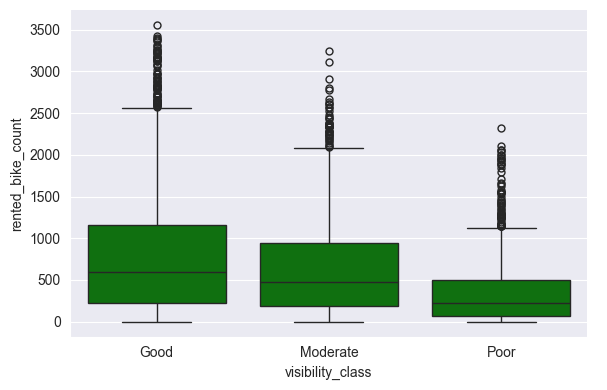

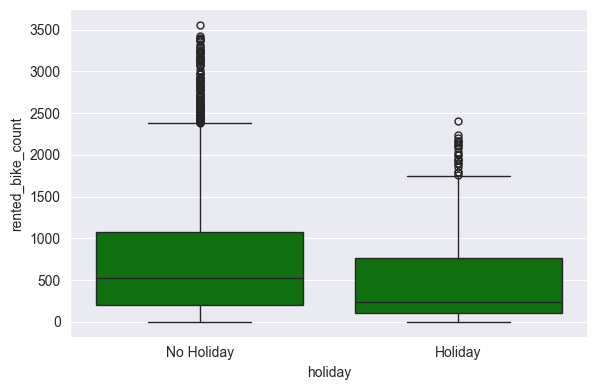

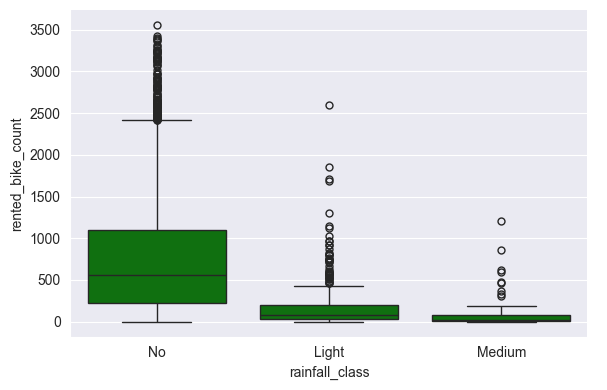

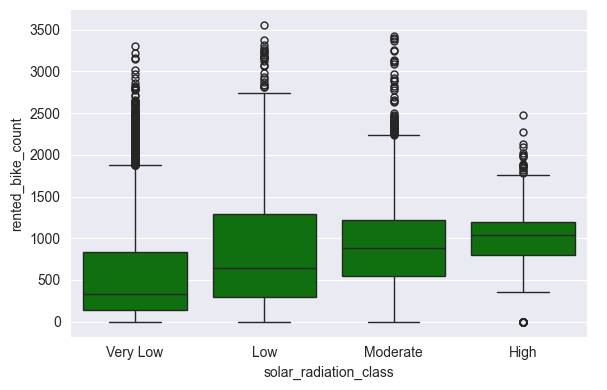

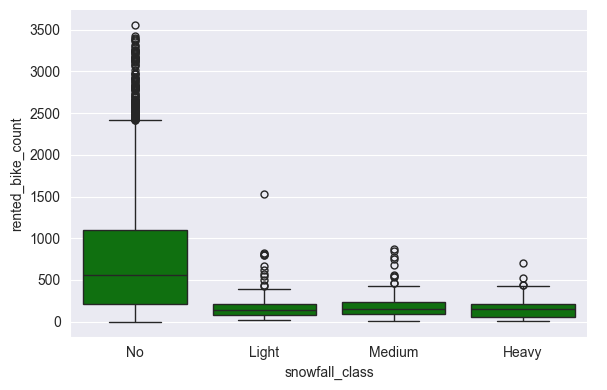

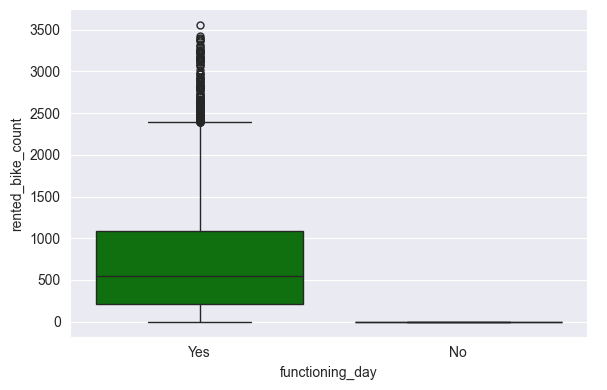

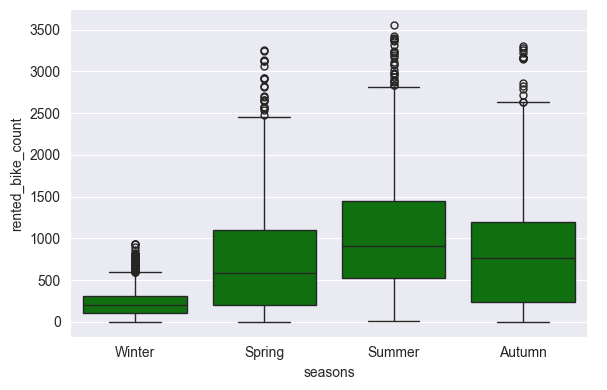

In [31]:
#Catplot for categorical varibales
plot_discrete_cols(raw_df, cat_cols)

* The demand is less during less visibiloty.
* It seems like even if the solar radiation increases, there is increase in hte median demand of the bikes, which makes less sense..

##### Is there a significant difference between the demands for Non holiday and holiday seasons?

H0: Demands during holiday season and Non Holiday seasons are the same.

H1: Demands during both season are not same.

alpha = 0.05

In [32]:
# Hypothesis Testing
holiday_demands = raw_df.query("holiday=='Holiday'")['rented_bike_count']
non_holiday_demands = raw_df.query("holiday=='No Holiday'")['rented_bike_count']

holiday_demands.shape , non_holiday_demands.shape

((432,), (8328,))

In [33]:
def check_difference(holiday_demands, non_holiday_demands):
    # Assuming `group_A` and `group_B` are the data for the two groups
    stat, p_value = mannwhitneyu(holiday_demands, non_holiday_demands, alternative='two-sided')

    if p_value < 0.05:
        print("Both Groups have differnt median. Therefore not the same", (stat, p_value))

    else:
        print("Groups have same median demand.")

check_difference(holiday_demands, non_holiday_demands)

Both Groups have differnt median. Therefore not the same (np.float64(1364325.0), np.float64(2.279911048361832e-17))


#### Temporal Variables vs Target Variable

In [34]:
raw_df

,date,rented_bike_count,hour,temperature,humidity,wind_speed,visibility,solar_radiation,rainfall,snowfall,seasons,holiday,functioning_day,rainfall_class,snowfall_class,visibility_class,solar_radiation_class
0,01/12/2017,254,0,-5.2,37,2.2,2000,0.0,0.0,0.0,Winter,No Holiday,Yes,No,No,Good,Very Low
1,01/12/2017,204,1,-5.5,38,0.8,2000,0.0,0.0,0.0,Winter,No Holiday,Yes,No,No,Good,Very Low
2,01/12/2017,173,2,-6.0,39,1.0,2000,0.0,0.0,0.0,Winter,No Holiday,Yes,No,No,Good,Very Low
3,01/12/2017,107,3,-6.2,40,0.9,2000,0.0,0.0,0.0,Winter,No Holiday,Yes,No,No,Good,Very Low
4,01/12/2017,78,4,-6.0,36,2.3,2000,0.0,0.0,0.0,Winter,No Holiday,Yes,No,No,Good,Very Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,30/11/2018,1003,19,4.2,34,2.6,1894,0.0,0.0,0.0,Autumn,No Holiday,Yes,No,No,Good,Very Low
8756,30/11/2018,764,20,3.4,37,2.3,2000,0.0,0.0,0.0,Autumn,No Holiday,Yes,No,No,Good,Very Low
8757,30/11/2018,694,21,2.6,39,0.3,1968,0.0,0.0,0.0,Autumn,No Holiday,Yes,No,No,Good,Very Low
8758,30/11/2018,712,22,2.1,41,1.0,1859,0.0,0.0,0.0,Autumn,No Holiday,Yes,No,No,Good,Very Low


In [35]:
#daily data
raw_df['date'] = pd.to_datetime(raw_df['date'], dayfirst=True)
yearly_data = raw_df.groupby(['seasons', 'date'])['rented_bike_count'].median().reset_index()

yearly_data.describe()

,date,rented_bike_count
count,365,365.000000
mean,2018-06-01 00:00:00,653.094521
min,2017-12-01 00:00:00,0.000000
25%,2018-03-02 00:00:00,253.000000
50%,2018-06-01 00:00:00,696.000000
75%,2018-08-31 00:00:00,1025.000000
max,2018-11-30 00:00:00,1436.000000
std,NaN,401.385892


<Axes: xlabel='date', ylabel='rented_bike_count'>

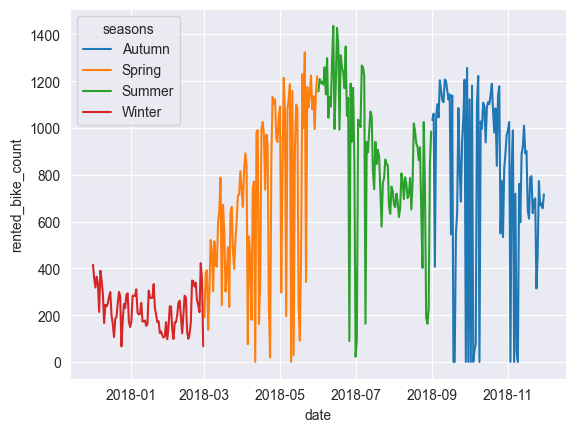

In [36]:
sns.lineplot(x=yearly_data['date'], y=yearly_data['rented_bike_count'], hue=yearly_data['seasons'])

* During the winter season the demand is below median, once the winter is over during the spring the demand increases and reaches the peak.

In [37]:
#monthly trend
monthly_trend = raw_df.copy()
monthly_trend['day'] = raw_df['date'].apply(lambda x: x.day)

monthly_trend = monthly_trend.groupby('day')['rented_bike_count'].median().reset_index()
monthly_trend.describe()

,day,rented_bike_count
count,31.000000,31.000000
mean,16.000000,508.919355
std,9.092121,99.062110
min,1.000000,308.500000
25%,8.500000,430.000000
50%,16.000000,524.000000
75%,23.500000,590.250000
max,31.000000,709.500000


<Axes: xlabel='day', ylabel='rented_bike_count'>

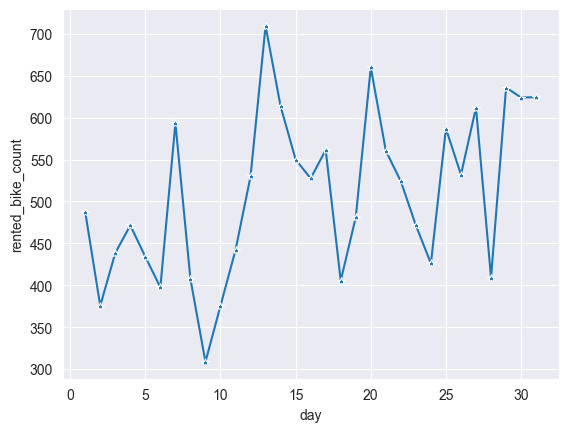

In [38]:
sns.lineplot(x=monthly_trend['day'], y=monthly_trend['rented_bike_count'], marker='*')

In [39]:
#daily pattern
daily_trend = raw_df.groupby('hour')['rented_bike_count'].median().reset_index()
daily_trend.describe()

,hour,rented_bike_count
count,24.000000,24.000000
mean,11.500000,683.666667
std,7.071068,370.479673
min,0.000000,119.000000
25%,5.750000,419.750000
50%,11.500000,694.500000
75%,17.250000,920.500000
max,23.000000,1548.000000


<Axes: xlabel='hour', ylabel='rented_bike_count'>

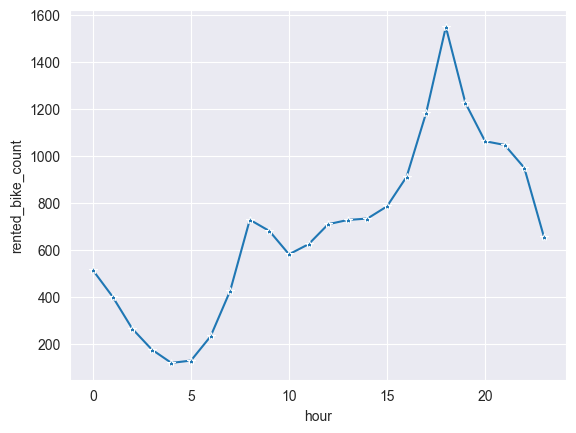

In [40]:
sns.lineplot(x=daily_trend['hour'], y=daily_trend['rented_bike_count'], marker='*')

<Axes: xlabel='weekday', ylabel='rented_bike_count'>

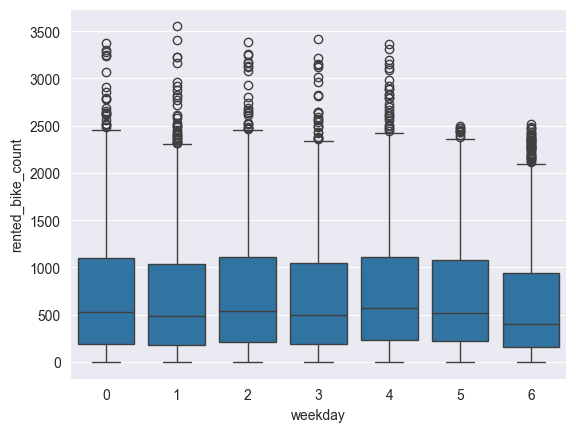

In [41]:
#week day or not 
raw_df['weekday'] = raw_df['date'].dt.weekday

sns.boxplot(x=raw_df['weekday'], y=raw_df['rented_bike_count'])

There is no much difference between the weekend vs weekdays demands.